<a href="https://colab.research.google.com/github/juniajeff/Deep_Learning_training/blob/main/softmax_training(not_enough_gpu_power).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
from IPython import display
from d2l import torch as d2l
from torch.utils.data import DataLoader

In [ ]:
batch_size_train = 64
batch_size_test = 1000

Initializing the MNIST training set. Using root parameter to define where to save data, train parameter is set to true because we are initializing the MNIST training dataset. The download parameter is set to true because we want to download it if it's not already present in data folder. The transform parameter is set to none because we don't want to apply any image manipulation transform at this time.

In [ ]:
train_iter = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])), batch_size=batch_size_train, shuffle=True)

C:\Users\asdfq\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Initializing the MNIST test set. Train parameter is set to false because we want test set, not the train set we set download to true and transform to none.

In [ ]:
test_iter = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])), batch_size=batch_size_test, shuffle=True)

In [ ]:
len(train_iter)

938

In [ ]:
len(test_iter)

10

Initialazing model parameters. Each image in dataset is 28x28. Image is flatten and become a vector 
of length 784.
Torch.normal - returns a tensor of normal distributions whose mean and standard deviation are given.

In [ ]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

Defining the softmax operation. Making a multidimensional matrix containing elements of a single data type.
We have two dimensional tensor here with shape (1,3). Dimenaions of the matrix are saved.

In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

Implementing foftmax operation. The broadcasting mechanism is applied here.

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition 

Trying to check the result. Using softmax we turn each element into a non-negative namber and each row sums up to 1.

In [ ]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0186, 0.0583, 0.1114, 0.3561, 0.4555],
         [0.1376, 0.2206, 0.0741, 0.1638, 0.4040]]),
 tensor([1.0000, 1.0000]))

Defining the model.
Implementing the softmax regression model. 
torch.matmul - matrix product of two tensors. Result depends on tensors.

In [ ]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

Defining the loss function.
Next step is implementing cross-entropy loss function.
Instead of iterating each element we are picking them all by a single operator. 
y_hat - sample data with with 2 examples of predicted probabilities over 3 classes and their corresponding labels "y". 

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Implementing loss function

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

Classification accuracy.
(argmax is an operation that finds the argument that gives the maximum value from a target function)
Argmax is needed to find the highest predicted probabaility to make strong prediction.

In [ ]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

the classification accuracy rate is 0.5

In [ ]:
accuracy(y_hat, y) / len(y)

0.5

Evaluating the accuracy for net model in dataset. 


In [ ]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # Number of correct predictions, number of total predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

Accumulator is the class for multiplying sums over n variables. 2 variables are made for correct predictions and total predictions. Accumulation is hppening while iterating a dataset.

In [ ]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Checking the accuracy by random weights.

In [ ]:
evaluate_accuracy(net, test_iter)

0.1029

Training.
Making a training loop for softmax regression. Restructuring the implementation to make it reusable. 

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

The animator class helps to plot the data in animation and show the graph at the moment it is producing. 
(just making a graph)

In [ ]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

Training function.
The following training function then trains a model `net` on a training dataset accessed via `train_iter` for multiple epochs, which is specified by `num_epochs`.

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model net"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

Using minibatch SGD to optimize the loss function wit learning rate 0.1. Learning rate scales the magnitude of the model's weight updates in order to minimize the model's loss.

Batch size 64, learning rate - 0.1, epochs - 10

In [ ]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

training model with 10 epochs

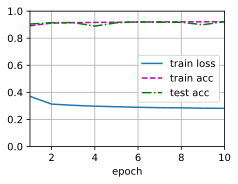

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

Batch size - 64, learning rate - 0.2, epochs - 10.
The result is worse than in the previous learning arte. Loss function is same and not getting down, accurasy stays same or slowly dropping. With the lr=0.1 accuracy was slowly going up.

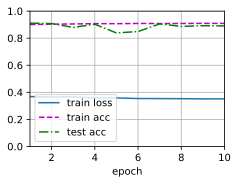

In [ ]:
lr = 0.2

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)    

Batch size - 256, learning rate - 0.1, epochs - 10.
This time batch size is much bigger. It is hard to say if somethings changed, the results look pretty similar. Just test accuracy and train accuracy are little bit closer.

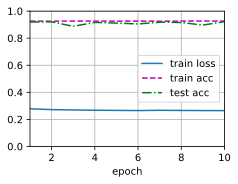

In [ ]:
lr = 0.1
batch_size = 256

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)  

Batch size - 256, learning rate - 0.1, epochs - 100.
This time epochs were increased. Loss function goes down very slowly or just being straight. Another parametres are same.

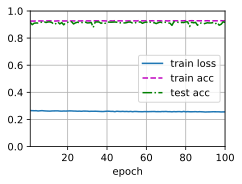

In [ ]:
lr = 0.1
batch_size = 256


def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 100
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)  

Batch size - 412, learning rate - 0.1, epochs - 1000.
This time the process was taking too long time (more than 40 minutes) so i had to interrupt it. But already at this part of graph we can see that it's pretty similar to previous graphs. It looks like there is no change in results if I change the parametres. The only influencing parameter is learning rate.

KeyboardInterrupt: 

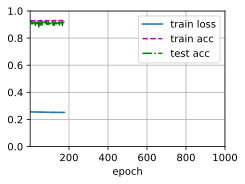

In [ ]:
lr = 0.1
batch_size = 412


def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 1000
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

Data prediction and checking if the network works well.

In [ ]:
# Disable grad
#with torch.no_grad():
    
    # Retrieve item
 #   index = 256
  #  item = dataset[index]
  #  image = item[0]
   # true_target = item[1]
    
    # Generate prediction
    #prediction = mlp(image)
    
    # Predicted class value using argmax
    #predicted_class = np.argmax(prediction)
    
    # Reshape image
    #image = image.reshape(28, 28, 1)
    
    # Show result
    #plt.imshow(image, cmap='gray')
    #plt.title(f'Prediction: {predicted_class} - Actual target: {true_target}')
    #plt.show()

In [ ]:
#labels = []
#for
#def predict_ch3(net, test_iter, n=6):  #@save
 #   """Predict labels."""
  #  for X, y in test_iter:
   #     break
    #trues = torchvision.datasets.MNIST(y)
    #preds = test_iter.dataset.targets(net(X).argmax(axis=1))
    #titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    #d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

#predict_ch3(net, test_iter)

AttributeError: type object 'MNIST' has no attribute 'item'

the problem of directory is keep hapenning, i can't solve it

In [ ]:
post = r'C:\Users\asdfq\Desktop\d2l-en\pytorch\chapter_linear-networks\number_1.png'

images = []
labels = []
for image_name in os.listdir(post):
    img = cv2.imread(post%s % image_name, 0)
    images.append(img.reshape(1, -1))
    labels.append(int(image_name[0]))
tensor = np.concatenate(images, axis=0)

tensor = torch.from_numpy(tensor).float()
labels = torch.tensor(labels)

tensor /= 255.0
tensor = (tensor - 0.1307) / 0.3081

print(accuracy(net(tensor), labels) / len(images))

NotADirectoryError: [WinError 267] 디렉터리 이름이 올바르지 않습니다: 'C:\\Users\\asdfq\\Desktop\\d2l-en\\pytorch\\chapter_linear-networks\\number_1.png'

Data augmentation. It is working, but i did not have time to finish plotting the graph, it was extremely slow.
For obtaining higher accuracy in computer vision.
RandomRotation rotates image by angle. 

KeyboardInterrupt: 

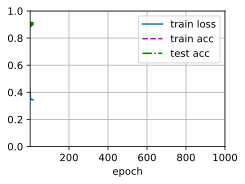

In [ ]:
train_iter = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.RandomRotation(10),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])), batch_size=batch_size_train, shuffle=True)
lr = 0.1
batch_size = 128
torch.manual_seed(0)
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)
print(evaluate_accuracy(net, test_iter))